# Финальный проект: вариант 2

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import scipy.stats as ss
import pingouin as pg



%matplotlib inline

## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.



#### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

+ __groups.csv__ - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [2]:
groups = pd.read_csv('groups.csv', sep=';', encoding='ISO-8859-1') 
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


+ __groups_add.csv__ - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [3]:
groups_add = pd.read_csv('groups_add.csv', sep=',', encoding='ISO-8859-1') 
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


+ __active_studs.csv__ - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [4]:
active_studs = pd.read_csv('active_studs.csv', sep=';', encoding='ISO-8859-1') 
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


+ __checks.csv__ - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [5]:
checks = pd.read_csv('checks.csv', sep=';', encoding='ISO-8859-1') 
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


### Предобработка данных
Посмотрим на размеры и количесво уникальных значений в датасетах

In [6]:
groups.shape

(74484, 2)

In [7]:
groups_add.shape

(92, 2)

In [8]:
active_studs.shape

(8341, 1)

In [9]:
checks.shape

(541, 2)

Удалим возможые дубликаты значений

In [10]:
groups = groups.drop_duplicates();
groups_add = groups_add.drop_duplicates();
active_studs = active_studs.drop_duplicates();
checks = checks.drop_duplicates();

In [11]:
groups.shape

(74484, 2)

In [12]:
groups_add.shape

(92, 2)

In [13]:
active_studs.shape

(8341, 1)

In [14]:
checks.shape

(541, 2)

Размеры датасетов не изменились после удаления дубликатов

---

Посмотрим на типы значений в датасете и количесво уникальных значений

In [15]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [16]:
groups.dtypes

id      int64
grp    object
dtype: object

In [17]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [18]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [19]:
active_studs.nunique()

student_id    8341
dtype: int64

In [20]:
active_studs.dtypes

student_id    int64
dtype: object

In [21]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [22]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Для начала объедим датафреймы groups_add и groups

In [23]:
groups_all = pd.concat([groups_add, groups]).reset_index(drop = True).rename(columns={'id': 'student_id'})
groups_all

,student_id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
74571,5692459,B
74572,5692572,B
74573,5692865,B
74574,5693667,B


Проверим новую таблицу на возможные дубликаты значений

In [24]:
groups_all.shape

(74576, 2)

In [25]:
groups_all = groups_all.drop_duplicates();

In [26]:
groups_all.shape

(74576, 2)

Теперь объединим датафреймы для дальнейшнего анализа, нам необходимо отобрать пользователей, которые зашли на платформу в дни проведения эксперимента.

In [27]:
active_all = active_studs.merge(groups_all, on = 'student_id', how='left')
active_all 

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


Проверим новую таблицу на возможные дубликаты значений

In [28]:
active_all.shape

(8341, 2)

In [29]:
active_all.dropna();
active_all = active_all.drop_duplicates();

In [30]:
active_all.shape

(8341, 2)

Далее добавим данные из таблицы с чеками, объединять будем так, чтобы оставить только тех пользователей, кому была присвоина метка 'А' или 'В' (из датафрейма active_all), а так же добавим колонку "buy_or_not" с фильрацией по полльзователям, где not_buy - покупки не было, а buy - покупка была. 

Так же к колонке "rev" заменим значения где покупки нет на 0.  

In [31]:
active_and_buy = active_all.merge(checks, on = 'student_id', how='left')
active_and_buy['buy_or_not'] = active_and_buy.rev.notnull()
active_and_buy['buy_or_not'] = active_and_buy.buy_or_not.replace(False, 'not_buy')
active_and_buy['buy_or_not'] = active_and_buy.buy_or_not.replace(True, 'buy')
active_and_buy['rev'] = active_and_buy.rev.fillna(0)
active_and_buy

,student_id,grp,rev,buy_or_not
0,581585,A,0.0,not_buy
1,5723133,A,0.0,not_buy
2,3276743,B,0.0,not_buy
3,4238589,A,0.0,not_buy
4,4475369,B,0.0,not_buy
...,...,...,...,...
8336,1794344,B,0.0,not_buy
8337,296883,B,0.0,not_buy
8338,3598448,B,0.0,not_buy
8339,3610547,B,290.0,buy


In [32]:
active_and_buy.shape

(8341, 4)

Удалим возможные дубликаты

In [33]:
active_and_buy = active_and_buy.drop_duplicates();

In [34]:
active_and_buy.shape

(8341, 4)

Составим таблицу с подсчетом сколько пользователей совершали оплату, а сколько нет из групп 'А' и 'В'

In [35]:
buyers_count = active_and_buy.groupby(['grp', 'buy_or_not'], as_index=False) \
.agg({'rev': 'count'}) \
.rename(columns={'rev': 'buyers_count'}) 

buyers_count

,grp,buy_or_not,buyers_count
0,A,buy,78
1,A,not_buy,1460
2,B,buy,314
3,B,not_buy,6489


Обработка и подготовка данных заверщена

---

#### Необходимо понять:
+ зависит ли наличие нового экрана оплаты на то, совершит ли пользователь покупку (для этого используем Хи-квадрат),
+ проанализируем различается ли средняя сумма покупки для пользователей групп 'А' и 'В', которые совершали оплату, для этого необходимо дополнительно проанализировать данные для выбора метода,
+ проанализировать среди купивших курс в обоих группах 'А' и 'В' отличается ли CR, ARPPU и ARPU (для других метрик слишком мало данных)

---

### Анализ по критерию Хи-квадрат

In [36]:
### Переупорядочить данные в 2x2 для хи-квадрат
# 1) Разделить группы на два отдельных кадра данных 
A = buyers_count[buyers_count['grp'] == 'A'] 
B = buyers_count[buyers_count['grp'] == 'B']
# 2) A-покупка,    
A_buy = A.query("buy_or_not == 'buy'").reset_index()
A_buy = A_buy.buyers_count[0]
# A-без покупки,
A_not_buy = A.query("buy_or_not == 'not_buy'").reset_index()
A_not_buy = A_not_buy.buyers_count[0]
# B-покупка,
B_buy = B.query("buy_or_not == 'buy'").reset_index()
B_buy = B_buy.buyers_count[0]
# B-без покупки
B_not_buy = B.query("buy_or_not == 'not_buy'").reset_index()
B_not_buy = B_not_buy.buyers_count[0]

In [37]:
# 3) Создать массив
T = np.array([[A_buy, A_not_buy], [B_buy, B_not_buy]])

In [38]:
T

array([[  78, 1460],
       [ 314, 6489]], dtype=int64)

In [39]:
print(ss.chi2_contingency(T,correction=False))

Chi2ContingencyResult(statistic=0.5821513741106591, pvalue=0.44547028437158964, dof=1, expected_freq=array([[  72.28102146, 1465.71897854],
       [ 319.71897854, 6483.28102146]]))


Нулевая гипотеза формулируется как: две сравниваемые эмпирические выборки принадлежат к одной и той же генеральной совокупности. 

Так как pvalue > 0.05, то мы принимаем нулвую гипотезу, то есть разница между старой и новой версией __не__ имеет значение.


---

### Далее посмотрим отличается ли средняя сумма покупки 

Сформируем датафрейм для анализа, удалим пропущенные значения, так как если пользователю не присвоена группа 'А' или 'В', его покупки не дожны влиять на анализ.

Анализ активных __платящих__ пользователей

In [40]:
active_and_checks = checks.merge(active_all, on = 'student_id', how='left').dropna().reset_index(drop=True)
active_and_checks

,student_id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


In [41]:
active_and_checks_A = active_and_checks.query("grp == 'A'")
active_and_checks_B = active_and_checks.query("grp == 'B'")

Посмотрим на основные метрики по группам

In [42]:
active_and_checks.groupby('grp') \
.agg({'rev': ('count', 'sum', 'mean', 'median', 'std')}) \
.round(2)

rev                                   
    count       sum     mean  median     std
grp                                         
A      78   72820.0   933.59   585.0  919.93
B     314  394974.0  1257.88  1140.0  790.86

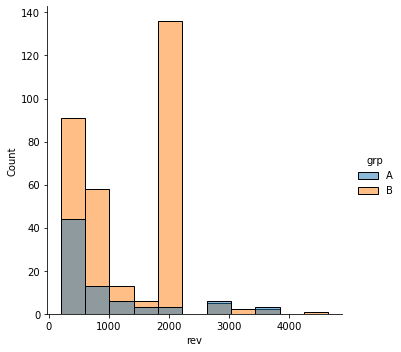

In [43]:
sns.displot(data=active_and_checks, x="rev", hue="grp")

По полученным данным можно сказать:

+ в группе 'В' оказалось больше пользователей, чем в группе 'А'
+ среднее значение и медиана сильно различаются между группами, в группе 'В' оба показателя выше

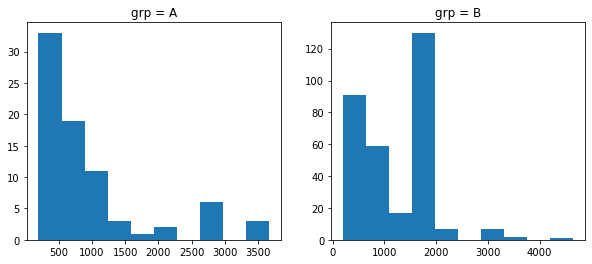

In [44]:
plt.figure(figsize=(10, 4));
# Одна строка, два столбца. Текущая ячейка - 1
plt.subplot(1, 2, 1);
plt.hist(active_and_checks.query('grp == "A"').rev);
plt.title("grp = A");

# Одна строка, два столбца. Текущая ячейка - 2
plt.subplot(1, 2, 2);
plt.hist(active_and_checks.query('grp == "B"').rev);
plt.title("grp = B");

Тип данных - количественный, нам необходимо проверить средние значения, у нас есть две группы для сравнения.

Для выбора подходящего метода необходимо проверить данные на нормальность.

In [45]:
pg.normality(active_and_checks_A.rev)

,W,pval,normal
rev,0.735324,1.498678e-10,False


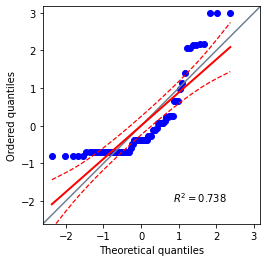

In [46]:
ax_grA = pg.qqplot(active_and_checks_A.rev, dist='norm')

In [47]:
pg.normality(active_and_checks_B.rev)

,W,pval,normal
rev,0.854724,1.543849e-16,False


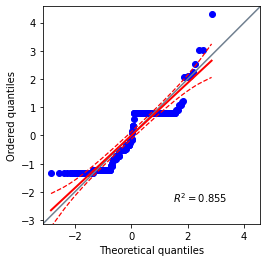

In [48]:
ax_grB = pg.qqplot(active_and_checks_B.rev, dist='norm')

In [49]:
pg.ttest(active_and_checks_A.rev,active_and_checks_B.rev).round(4)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.8617,106.9817,two-sided,0.0051,"[-548.94, -99.64]",0.3965,6.536,0.8782


Нулевая гипотеза t-test предполагает, что средние равны, так как p-val < 0.05, то мы отверагем нулевую гипотезу.

---

Однако, сделать однозначный вывод на данном этапе невозможно, в сравниваемых группах различное значение пользователей, а так же их количесво невелико, в соответсвии с чем можно применить бутстреп. 

In [50]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

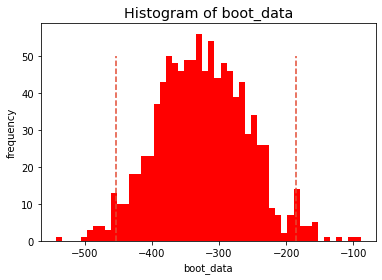

p_value: 1.1889637478403772e-06


In [51]:
booted_data = get_bootstrap(active_and_checks_A.rev, active_and_checks_B.rev)

print("p_value:", booted_data["p_value"])

Получилось, что p_value < 0.05, соответвенно, мы можем утверждать, что различия между группой 'A' и 'B' есть, и они статистически обоснованы.


Анализ среди __всех__ активных пользователей 

In [52]:
active_and_buy

,student_id,grp,rev,buy_or_not
0,581585,A,0.0,not_buy
1,5723133,A,0.0,not_buy
2,3276743,B,0.0,not_buy
3,4238589,A,0.0,not_buy
4,4475369,B,0.0,not_buy
...,...,...,...,...
8336,1794344,B,0.0,not_buy
8337,296883,B,0.0,not_buy
8338,3598448,B,0.0,not_buy
8339,3610547,B,290.0,buy


In [53]:
active_A = active_and_buy.query("grp == 'A'")
active_B = active_and_buy.query("grp == 'B'")

In [54]:
active_and_buy.groupby('grp') \
.agg({'rev': ('count', 'sum', 'mean', 'median', 'std')}) \
.round(2)

rev                                
    count       sum   mean median     std
grp                                      
A    1538   72820.0  47.35    0.0  290.49
B    6803  394974.0  58.06    0.0  313.77

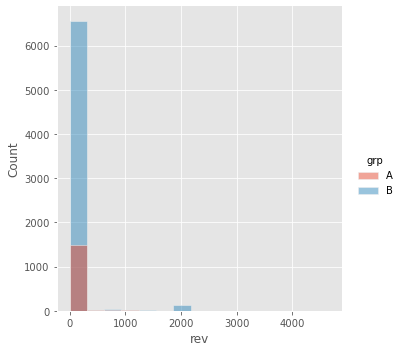

In [55]:
sns.displot(data=active_and_buy, x="rev", hue="grp")

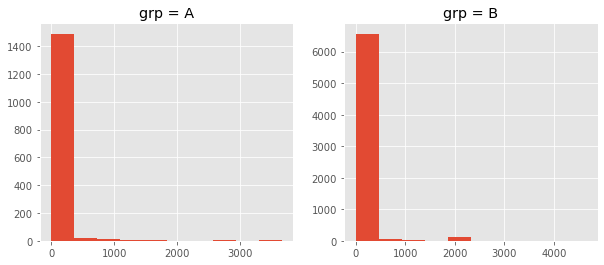

In [56]:
plt.figure(figsize=(10, 4));
# Одна строка, два столбца. Текущая ячейка - 1
plt.subplot(1, 2, 1);
plt.hist(active_and_buy.query('grp == "A"').rev);
plt.title("grp = A");

# Одна строка, два столбца. Текущая ячейка - 2
plt.subplot(1, 2, 2);
plt.hist(active_and_buy.query('grp == "B"').rev);
plt.title("grp = B");

In [57]:
pg.normality(active_A.rev)

,W,pval,normal
rev,0.154167,0.0,False


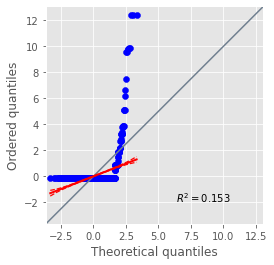

In [58]:
ax_grA = pg.qqplot(active_A.rev, dist='norm')

In [59]:
pg.normality(active_B.rev, method="jarque_bera")

,W,pval,normal
rev,547732.488043,0.0,False


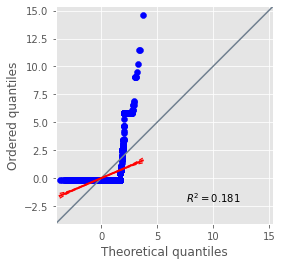

In [60]:
ax_grA = pg.qqplot(active_B.rev, dist='norm')

Данные не прошли проверку на нормальность, используем t-test

In [61]:
pg.ttest(active_A.rev, active_B.rev).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286,2416.748,two-sided,0.198,"[-27.04, 5.62]",0.035,0.073,0.232


Нулевая гипотеза t-test предполагает, что средние равны, так как p-val > 0.05, то мы принимаем нулевую гипотезу, то есть средние значения покупки среди всех активных пользователей одинаковы.

### Расчет CR, ARPPU и ARPU

---

Посмотрим отличается ли метрика CR, ARPPU, ARPU между двумя группами 'А' и 'В' 

Коэффициент конверсии CR это процент перехода в целевое действие (в нашем случае в оплату) 

ARPPU это средний доход на платящего пользователя 

ARPU это средний доход с привлечённого пользователя

In [62]:
for_cr = buyers_count.pivot(index='grp', columns='buy_or_not', values='buyers_count') \
.reset_index()

metrics = active_and_checks.groupby(['grp'], as_index=False) \
.agg({'rev': 'sum', 'student_id': 'count'}) \
.rename(columns={'student_id': 'student_count_buy', 'rev': 'rev_all'})
metrics['CR'] = ((for_cr.buy / (for_cr.buy + for_cr.not_buy)) * 100).round(2)
metrics['ARPPU'] = (metrics.rev_all / metrics.student_count_buy).round(2)
metrics['ARPU'] = ((metrics.CR/100) * metrics.ARPPU).round(2)
metrics

,grp,rev_all,student_count_buy,CR,ARPPU,ARPU
0,A,72820.0000,78,5.07,933.59,47.33
1,B,394974.0035,314,4.62,1257.88,58.11


Данные конверсий CR отличаются, но судя по статистическому анализу, эти различия несущесвенны, так как количесво покупающих и не покупающих пользователь после введения нового экрана оплаты не изменилось. 

Значение ARPPU для группы 'В' оказалось выше, судя по статистическому анализу эти различия являются статистически важными.

Значение ARPU для группы 'В' оказалось выше, но судя по статистическому анализу эти различия __не__ являются статистически важными.

### Выводы:


1. Новый экран оплаты не оказал влияния на факт покупки, что подтвердил анализ по критерию Хи-квадрат, в соответвии с чем и на конверсию, стоит обратить внимание на воронку продаж, для более детального анализа этого процесса необходимо больше данных, на текущий момент сказать почему так происходит невозможно. 


2. Метрика ARPPU для группы 'В' оказались выше (1257.88), чем для 'А' (933.59), можно сделать вывод, что новый экран повлиял на эти показатели, статистическую значимость этих измений подтвердил T-test и бутстреп.


3. Метрика ARPU хоть и оказалась выше, но статистически этот показатель не имеет значимости.


По идее, пользователь попадает на экран оплаты в момент решения купить ему услугу или нет, поэтому конверсия практически не изменилась в период проведения эксперимента, ведь пользователь не видит новый экран, если не собирается совершить покупку, так же наверняка на сайте сущесвуют различные виды услуг, соответвенно разные цены, так как метрика ARPPU увеличились, можно предположить, что новая механика оплаты положительно влияет на покупку более дорогих услуг. 

Однако, в данных присутвуют пользователи купившие на сумму около 2000, причем только в группе 'В', с чем связанно данное явление не ясно, возможно это выброс, возможно только на новом экране оплаты появилась услуга по этой цене. 

Так же в данных обнаружены пользователи, купившие услуги, но по каким-то причинам не попавшие в активные.

В соответствии с вышеперечисленным считаю, что необходимо разобраться со сбром данных, проверить аномальные покупки на сумму около 2000 рублей и обратить внимание на воронку продаж, новую механику на данном этапе вводить опасно, рекомендую продолжить тестирование.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

#### 2.1.2 Задача

Дана таблица default.peas:

| Название атрибута  | Тип атрибута  | Смысловое значение                      |
|:------------------ |:--------------| :---------------------------------------|
| st_id              | int           | ID ученика                              |
| timest             | timestamp     | Время решения карточки                  |
| correct            | bool          | Правильно ли решена горошина?           |
| subject            | text          | Дисциплина, в которой находится горошина|

	
Необходимо написать *__оптимальный__* запрос, который даст информацию о количестве очень усердных студентов.

_NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._



Подключаемся к clickhouse.lab.karpov.courses для выполнения SQL-запрсов в среде Python

In [63]:
connection = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Создаем запрос

In [64]:
query_1 = """
SELECT 
    COUNT(st_id) AS diligent_student
    
FROM 
    (SELECT 
    st_id,
    SUM(correct) AS correct_solution
    FROM
    default.peas
    WHERE 
    toUnixTimestamp(timest) > toUnixTimestamp(date_sub(timest, interval 1 month))
    GROUP BY
    st_id
    HAVING 
    correct_solution >= 20)



    """
# отправляем запрос и записываем результат в пандасовский датафрейм
diligent_students = ph.read_clickhouse(query_1, connection=connection)
diligent_students

,diligent_student
0,136


Получаем, что студенов, правильно решивших 20 "горошин" 136 на текущее время, если бы было необходимо найти студетов в обновляемой базе данных, можно было бы использовать запрос:

+ EXTRACT(MONTH FROM timest) = EXTRACT(MONTH FROM DATE_TRUNC('month', NOW()::DATE))

Так мы получали бы актуальную информацию об успешных студентах.

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), 

default.studs:

| Название атрибута  | Тип атрибута  | Смысловое значение                      |
|:------------------ |:--------------| :---------------------------------------|
| st_id              | int           | ID ученика                              |
| test_grp           | text          |  Метка ученика в данном эксперименте    |



и default.final_project_check:


| Название атрибута  | Тип атрибута  | Смысловое значение                      |
|:------------------ |:--------------| :---------------------------------------|
| st_id              | int           | ID ученика                              |
| sale_time          | timestamp     | Время покупки                           |
| money              | int           | Цена, по которой приобрели данный курс  |
| subject	         | text 	     |                                         |
	

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

+ ARPU 
+ ARPAU 
+ CR в покупку 
+ СR активного пользователя в покупку 
+ CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

*__Активным__ считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.*

*__Активным__ по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.*

In [65]:
query_2 = """
SELECT 
        test_grp,
        
        SUM(final.money) / uniqExact(studs.st_id) AS ARPU,
        
        SUMIf(final.money, 
               peas.correct_solution > 10) 
        / 
        uniqIf(studs.st_id, 
               peas.correct_solution > 10) AS ARPAU,
        
        uniqIf(studs.st_id, 
               final.money != 0) 
        / 
        uniqExact(studs.st_id) AS CR,    
               
        uniqIf(studs.st_id, 
            final.money != 0 and 
            peas.correct_solution > 10) 
        / 
        uniqIf(studs.st_id, 
            peas.correct_solution > 10) AS active_CR,
        
        uniqIf(studs.st_id, 
            final.subject = 'Math' and 
            final.money != 0 and 
            peas.active_in_math >= 2) 
            /
        uniqIf(studs.st_id, 
            peas.active_in_math >= 2) AS math_active_CR
                        
FROM 
    studs AS studs
        
LEFT JOIN                          //* джойним для получения информации об оплате //*
    final_project_check AS final
ON 
    studs.st_id = final.st_id
        
LEFT JOIN                          //* джойним для получения информации о выполненых "горошинах" //*
    (
        SELECT 
            st_id, 
            SUMIf(correct, subject = 'Math') AS active_in_math, //* отдельно счиатем математиков //*
            
            SUM(correct) AS correct_solution                    //* счиатем количесво выполненных заданий //*
                                                                //* (в этой ячейке 0 или 1) //*
            
        FROM 
            peas
        GROUP BY 
            st_id
            
    ) AS peas 
        
ON 
    studs.st_id = peas.st_id

GROUP BY      //* групируем по группам //*
    test_grp



    """
# отправляем запрос и записываем результат в пандасовский датафрейм
metric = ph.read_clickhouse(query_2, connection=connection)
metric 

,test_grp,ARPU,ARPAU,CR,active_CR,math_active_CR
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [66]:
def funq():
    #загрузка основых датасетов
    groups_func = pd.read_csv('groups.csv', sep=';', header=0, names=['id', 'grp'])
    active_studs_func = pd.read_csv('active_studs.csv', header=0, names=['id'])
    checks_func = pd.read_csv('checks.csv', sep=';', header=0, names=['id', 'rev'])
    
    #удалим возможные дубликаты 
    groups_func = groups_func.drop_duplicates(keep=False);
    active_studs_func = active_studs_func.drop_duplicates(keep=False);
    checks_func = checks_func.drop_duplicates(keep=False);
    
    #во избежании падения кода, добавим функцию с проверкой, есть ли файл с обновлениями 
    try:
        groups_add_file = pd.read_csv(groups_add_df, header=0, names=['id', 'grp'])
        groups_func = pd.concat([groups_add_file, groups_func])
        print('Файл найден')
    except NameError:
        print('Файл отсутвует')
        
    #создадим датафрейм с активными пользователями 
    active_all_func = active_studs_func.merge(groups_func, on = 'id', how='left')
    active_all_func = active_all_func.drop_duplicates(keep=False);
    active_all_func = active_all_func.dropna().reset_index(drop=True) 
    
    #создадим датафрейм с активными пользователями и покупаками    
    active_and_buy_func = active_all_func.merge(checks_func, on = 'id', how='left')
    active_and_buy_func = active_and_buy_func.drop_duplicates(keep=False);
    active_and_buy_func = active_and_buy_func.reset_index(drop=True) 
    
    #добавим колонки с разделенем buy/not_buy, а так же отсутвующие значения зоплним нулями 
    active_and_buy_func = active_all_func.merge(checks_func, on = 'id', how='left')
    active_and_buy_func['buy_or_not'] = active_and_buy_func.rev.notnull()
    active_and_buy_func['buy_or_not'] = active_and_buy_func.buy_or_not.replace(False, 'not_buy')
    active_and_buy_func['buy_or_not'] = active_and_buy_func.buy_or_not.replace(True, 'buy')
    active_and_buy_func['rev'] = active_and_buy_func.rev.fillna(0)
    
    #создадим датафрейм с подсчетом суммы покупок по группам
    buyers_count_func = active_and_buy_func.groupby(['grp', 'buy_or_not'], as_index=False) \
    .agg({'rev': 'count'}) \
    .rename(columns={'rev': 'buyers_count'}).dropna().reset_index(drop=True) 
    
     #создадим датафрейм с активными пользователями, которые проводили оплату
    active_and_checks_func = checks_func.merge(active_all_func, on = 'id', how='left') \
    .dropna().reset_index(drop=True)
    
     
    #критерий Хи-квадрат  
    
    # 2) A-покупка,
    A_buy_func = buyers_count_func.query("buy_or_not == 'buy' and grp == 'A'")
    A_buy_func = A_buy_func.buyers_count[0]
    # A-без покупки,
    A_not_buy_func = buyers_count_func.query("buy_or_not == 'not_buy' and grp == 'A'")
    A_not_buy_func = A_not_buy_func.buyers_count[1]
    # B-покупка,
    B_buy_func = buyers_count_func.query("buy_or_not == 'buy' and grp == 'B'")
    B_buy_func = B_buy_func.buyers_count[2]
    # B-без покупки
    B_not_buy_func = buyers_count_func.query("buy_or_not == 'not_buy' and grp == 'B'")
    B_not_buy_func = B_not_buy_func.buyers_count[3]
    
    T_func = np.array([[A_buy_func, A_not_buy_func], [B_buy_func, B_not_buy_func]])
    chi = ss.chi2_contingency(T_func,correction=False)
    chi = chi.pvalue.round(3)
    
    #U-критерий Манна-Уитни
    purchase_grA_func = active_and_checks_func.query("grp == 'A'")
    purchase_grA_func = purchase_grA_func.rev
    purchase_grB_func = active_and_checks_func.query("grp == 'B'")
    purchase_grB_func = purchase_grB_func.rev
    mwu = ss.mannwhitneyu(purchase_grA_func, purchase_grB_func, 
                          use_continuity=True, alternative='two-sided')
    mwu = mwu.pvalue.round(5)
    
    #вычисление метрик 
    for_cr_func = buyers_count_func.pivot(index='grp', columns='buy_or_not', values='buyers_count') \
    .reset_index()

    metrics_func = active_and_checks_func.groupby(['grp'], as_index=False) \
    .agg({'rev': 'sum', 'id': 'count'}) \
    .rename(columns={'id': 'student_count_buy', 'rev': 'rev_all'})
    metrics_func['CR'] = ((for_cr_func.buy / (for_cr_func.buy + for_cr_func.not_buy)) * 100).round(2)
    metrics_func['ARPPU'] = (metrics_func.rev_all / metrics_func.student_count_buy ).round(2)
    metrics_func['ARPU'] = ((metrics_func.CR / 100)  * metrics_func.ARPPU).round(2)
 
    
    return chi, mwu, metrics_func

In [67]:
chi, mwu, metrics = funq()

print('Метрики rev_all(общая сумма заработка), student_count(количество студентов), CR, ARPPU, ARPU \n\n', metrics, '\n\n')
print('p-val для анализа по критерию Хи-квадрат:', chi)
print('p-val для анализа по критерию U-критерий Манна-Уитни:', mwu)


Файл отсутвует
Метрики rev_all(общая сумма заработка), student_count(количество студентов), CR, ARPPU, ARPU 

   grp      rev_all  student_count_buy    CR    ARPPU   ARPU
0   A   72820.0000                 78  5.08   933.59  47.43
1   B  393074.0035                313  4.61  1255.83  57.89 


p-val для анализа по критерию Хи-квадрат: 0.428
p-val для анализа по критерию U-критерий Манна-Уитни: 0.00027


Предположим, что нам отправили новый файл и он подгрузился к нам в папку.

In [68]:
groups_add_df = 'groups_add.csv'

In [69]:
chi_new, mwu_new, metrics_new = funq()

print('Метрики rev_all(общая сумма заработка), student_count(количество студентов), CR, ARPPU, ARPU \n\n', metrics_new, '\n\n')
print('p-val для анализа по критерию Хи-квадрат:', chi_new)
print('p-val для анализа по критерию U-критерий Манна-Уитни:', mwu_new)

Файл найден
Метрики rev_all(общая сумма заработка), student_count(количество студентов), CR, ARPPU, ARPU 

   grp      rev_all  student_count_buy    CR    ARPPU   ARPU
0   A   72820.0000                 78  5.07   933.59  47.33
1   B  394974.0035                314  4.62  1257.88  58.11 


p-val для анализа по критерию Хи-квадрат: 0.445
p-val для анализа по критерию U-критерий Манна-Уитни: 0.00025


Далее реализуем функцию для построения графиков

In [70]:
def grafs(metrics):
    
    figure, ax = plt.subplots(1, 3, figsize=(8, 5))
    

    ax_CR = sns.barplot(data = metrics, x = metrics.grp, y=metrics.CR, ax=ax[0], palette = "mako")
    ax_CR.set_xlabel('Метка группы', fontsize=10)
    ax_CR.set_ylabel('')
    ax_CR.set_ylim(0, 8)
    ax_CR.set_title('CR, %', fontsize=10)
    
    ax_ARPPU = sns.barplot(data = metrics, x = metrics.grp, y=metrics.ARPPU, ax=ax[1], palette = "mako")
    ax_ARPPU.set_xlabel('Метка группы', fontsize=10)
    ax_ARPPU.set_ylabel('')
    ax_ARPPU.set_title('ARPPU', fontsize=10)
    
    ax_ARPU = sns.barplot(data = metrics, x = metrics.grp, y=metrics.ARPU, ax=ax[2], palette = "mako")
    ax_ARPU.set_xlabel('Метка группы', fontsize=10)
    ax_ARPU.set_ylabel('')
    ax_ARPU.set_title('ARPU', fontsize=10)
    
    figure.tight_layout()

Для данных __без__ присоединенного файла:

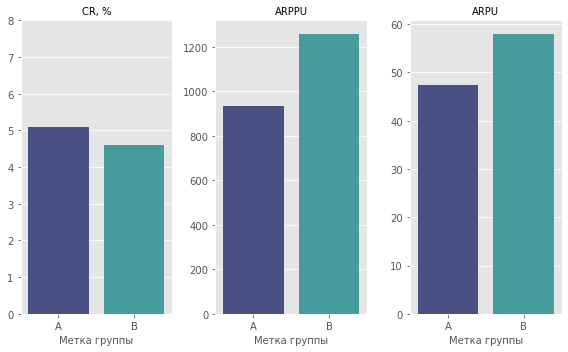

In [71]:
grafs(metrics)

Для данных __с__ присоединенным файлом:

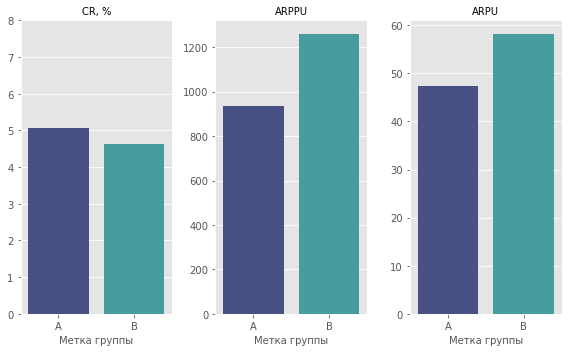

In [72]:
grafs(metrics_new)